### Harmonic-percussive separation with median filtering (testing on a music file)

In [83]:
import numpy as np
from scipy.fftpack import fft,ifft
from scipy.io.wavfile import read, write
import matplotlib.pyplot as plt


#### STFT and ISTFT functions

In [114]:
def stft(x, fs, N, hopSize):
    #returns short time fourier transform of signal x using parameters specified
    nframes = np.int32(np.ceil(len(x)/np.float32(hopSize)))
    x = np.concatenate((x, np.zeros(N)))
    win = np.hanning(N)
    Nfft = N
    Sxx = np.zeros((Nfft,nframes), dtype = complex)
    start = 0
    for k in range(nframes):
        x_win = x[start:start+N] * win
        Sxx[:,k] = np.fft.fft(x_win, Nfft)
        start += hopSize
    t = np.arange(nframes)*hopSize/fs
    f = np.fft.fftfreq(Nfft, 1./fs)
    return t,f,Sxx


def istft(Sxx,fs,N,hopSize):
    #returns inverse short time fourier transform given Sxx using overlap add
    Nfft,nframes = np.shape(Sxx)
    win = np.hanning(N)
    x = np.zeros((nframes*hopSize)+N, dtype = float)
    start = 0
    for k in range(nframes):
        x_seg = np.fft.ifft(Sxx[:,k],Nfft)
        x[start:start+N] += np.real(x_seg)*win
        start += hopSize
    #scale the signal
    W0 = np.sum(np.power(win,2));                  
    x = x*hopSize/W0;  
    t = np.linspace(0, len(x)/fs, len(x))
    return t,x
        
    
def plot_spectrogram(Sxx,t,f, str_title):
    #keep positive half of spectrum and normalize
    N = np.shape(Sxx)[0]
    N_half = np.int32(N/2)
    Sxx_pos = Sxx[:N_half]
    f_pos = f[:N_half]
    Sxx_norm = Sxx_pos/(np.max(np.abs(Sxx_pos)))
    eps = 10**-12

    plt.figure()
    plt.imshow(20*np.log10(np.abs(Sxx_norm)+eps), cmap = 'jet', extent=[0,max(t),0,max(f_pos)], interpolation='bilinear', aspect = 'auto', origin = 'lower')
    plt.title(str_title)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()
    

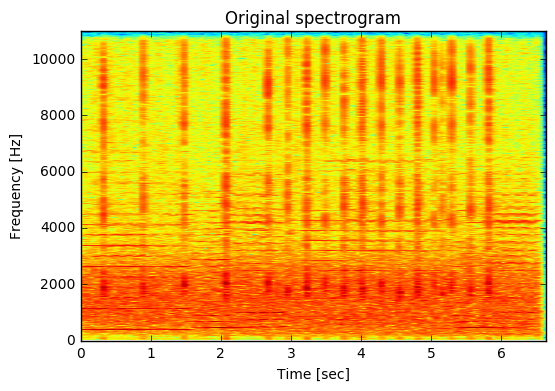

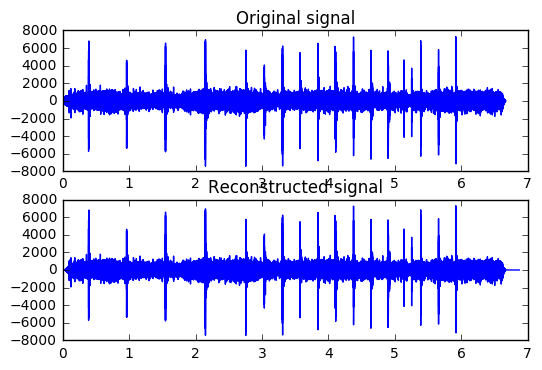

In [109]:
#read an audio file
(fs,x) = read('../../Downloads/CastanetsViolinApplause_Orig.wav')
x = x[:,0]
time = np.linspace(0,len(x)/fs,len(x))

#look at its spectrogram
N = 4096
hopSize = 1024
t,f,Sxx = stft(x, fs, N, hopSize)
plot_spectrogram(Sxx,t,f,'Original spectrogram')

#invert the spectrogram to get time domain signal
tr,xr = istft(Sxx,fs,N,hopSize)
write('../../Downloads/reconstructed_orig.wav',fs,xr)
plt.figure()
plt.subplot(211)
plt.plot(time,x)
plt.title('Original signal')
plt.subplot(212)
plt.plot(tr,xr)
plt.title('Reconstructed signal')
plt.show()

In [128]:
def median_filter(X, filter_length, axis=None):
    #median filter 2D signal X along axis specified
    #axis - 0 (along x-axis (time axis))
    #axis - 1 (along y-axis(frequency axis))
    #filter_length - length of median filter(in samples)
    Nfft, nframes = np.shape(X)
    Xfilt = np.zeros((Nfft,nframes), dtype = complex)
    
    if axis == 0:
        #make sure there are enough columns on either boundary to take median 
        X = np.hstack((np.tile(X[:,0],(filter_length,1)).T,X,np.tile(X[:,-1],(filter_length,1)).T))
        for n in range(nframes):
            Xfilt[:,n] = np.median(X[:,n:n+2*filter_length+1], axis = 1)
    elif axis == 1:
        #make sure there are enough rows on eiher boundary to take median
        X = np.vstack((np.tile(X[0,:], (filter_length,1)),X,np.tile(X[-1,:], (filter_length,1))))
        for k in range(Nfft):
            Xfilt[k,:] = np.median(X[k:k+2*filter_length+1,:], axis = 0)
            
    return Xfilt
    

#function for harmonic-percussive separation
def hpss(x,fs,N,beta = 2):
    #Step 1. get stft of x
    hopSize = np.int32(N/4)
    t,f,Sxx = stft(x,fs,N,hopSize)
    Nfft, nframes = np.shape(Sxx)
    eps = 10**-12
    #length of median filter along time axis = 200ms
    lt = 0.2*fs
    lt_bins = np.int32(np.round(lt/hopSize))
    #get harmonic content by median filtering along time axis
    Sxx_h = median_filter(np.abs(Sxx), lt_bins, axis = 0) 
    #length of median filter along frequency axis = 500Hz
    lf = 500
    lf_bins = np.int32(np.round((N/fs * lf)))
    #get percussive content by median filtering along frequency axis
    Sxx_p = median_filter(np.abs(Sxx), lf_bins, axis = 1)
    
    #get harmonic mask
    Mh = np.ma.make_mask(np.greater(np.divide(Sxx_h,(Sxx_p+eps)), beta))
    #get harmonic components
    Xh = np.multiply(Sxx, Mh)
    th,xh = istft(Xh,fs,N,hopSize)
    #get percussive mask
    Mp = np.ma.make_mask(np.greater_equal(np.divide(Sxx_p,(Sxx_h+eps)), beta))
    #get percussive components
    Xp = np.multiply(Sxx, Mp)
    tp, xp = istft(Xp,fs,N,hopSize)
    #get residual mask
    Mr = np.ones((Nfft,nframes)) - (Mh+Mp)
    #get residual components
    Xr = np.multiply(Sxx, Mr)
    tr, xr= istft(Xr,fs,N,hopSize)
    
    return t,f,Xh,Xp,Xr,xh[:len(x)],xp[:len(x)],xr[:len(x)]


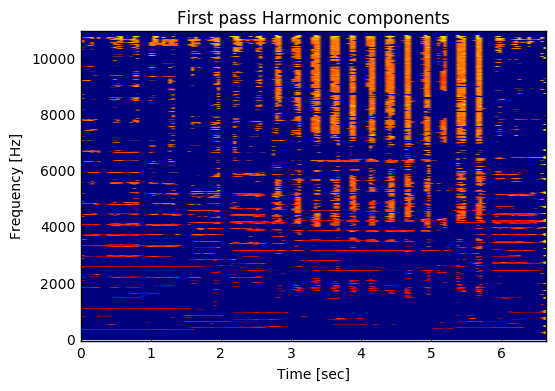

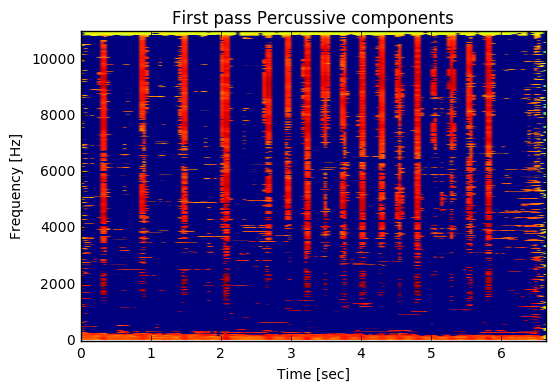

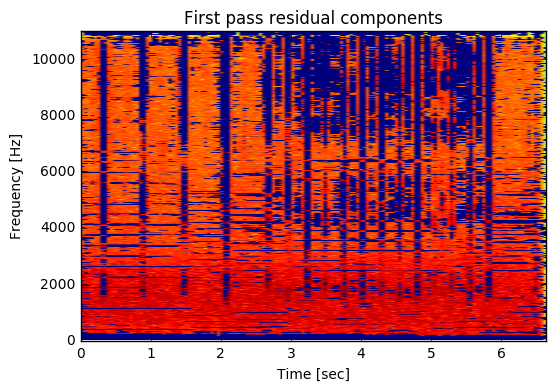

In [129]:
#first iteration
t,f,Xh,Xp,Xr,xh,xp,xr = hpss(x,fs,4096)
plot_spectrogram(Xh,t,f,'First pass Harmonic components')
plot_spectrogram(Xp,t,f,'First pass Percussive components')
plot_spectrogram(Xr,t,f,'First pass residual components')

write('../../Downloads/first_it_harm.wav',fs,xh)
write('../../Downloads/first_it_perc.wav',fs,xp)
write('../../Downloads/first_it_res.wav',fs,xr)

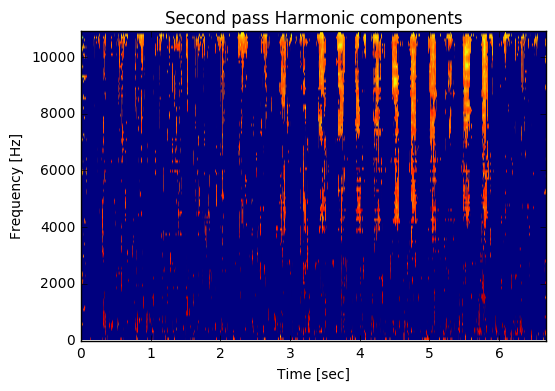

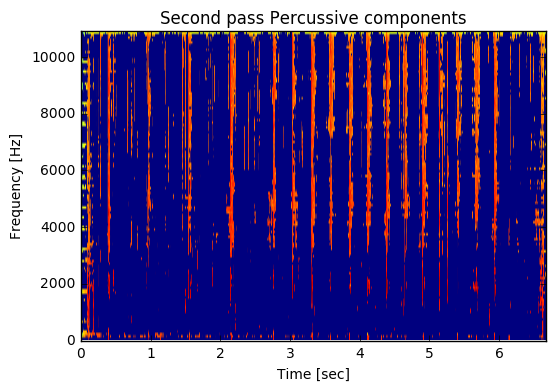

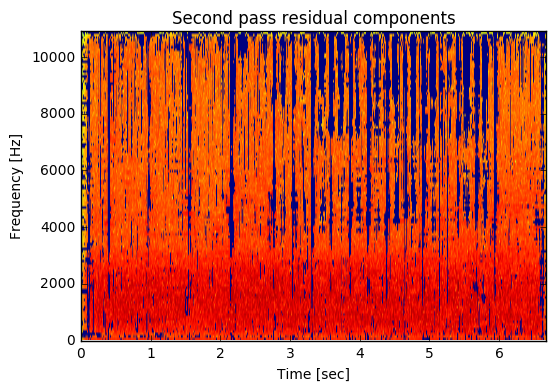

In [130]:
#second iteration
t,f,Xh2,Xp2,Xr2,xh2,xp2,xr2 = hpss(xr+xp,fs,256)
plot_spectrogram(Xh2,t,f,'Second pass Harmonic components')
plot_spectrogram(Xp2,t,f,'Second pass Percussive components')
plot_spectrogram(Xr2,t,f,'Second pass residual components')

write('../../Downloads/second_it_harm.wav',fs,xh2)
write('../../Downloads/second_it_perc.wav',fs,xp2)
write('../../Downloads/second_it_res.wav',fs,xr2)

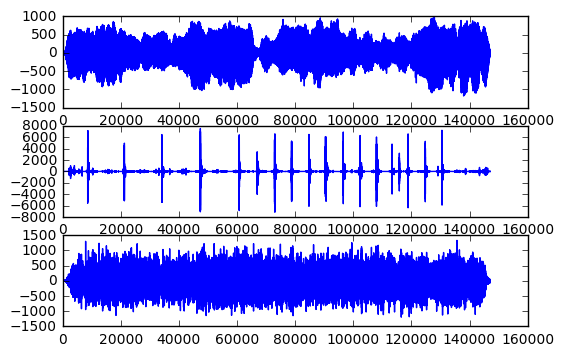

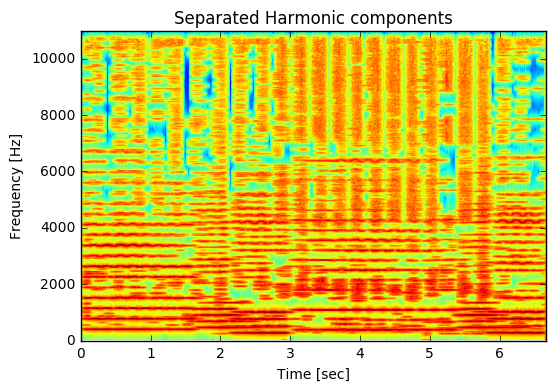

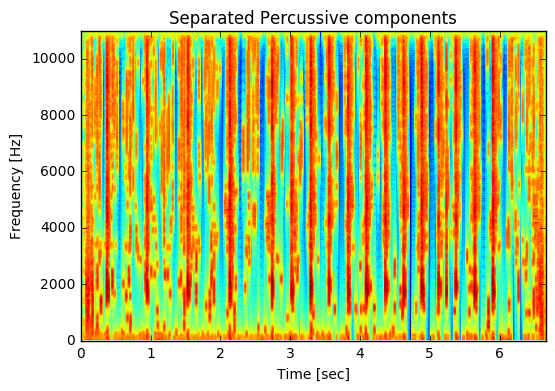

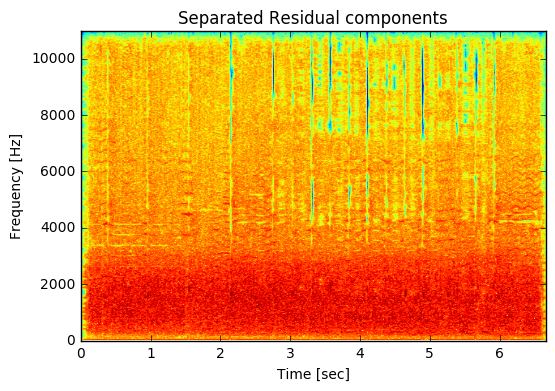

In [131]:
#final results
xhf = xh
xpf = xp2
xrf = xh2+xr2

plt.figure()
plt.subplot(311)
plt.plot(xhf)
plt.subplot(312)
plt.plot(xpf)
plt.subplot(313)
plt.plot(xrf)

write('../../Downloads/final_harm.wav',fs,xhf/max(abs(xhf)))
write('../../Downloads/final_perc.wav',fs,xpf/max(abs(xpf)))
write('../../Downloads/final_res.wav',fs,xrf/max(abs(xrf)))

t,f,Xhf = stft(xhf,fs,1024,256)
t,f,Xpf = stft(xpf,fs,1024,256)
t,f,Xrf = stft(xrf,fs,1024,256)

plot_spectrogram(Xhf,t,f,'Separated Harmonic components')
plot_spectrogram(Xpf,t,f,'Separated Percussive components')
plot_spectrogram(Xrf,t,f,'Separated Residual components')
